# Settings

In [135]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '../data')
OUTPUT_DIR = os.path.join(BASE_DIR, '../output')

In [136]:
model_name = 'klue/bert-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name)

data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
dataset_train, dataset_valid = train_test_split(data, test_size=0.3, stratify=data['target'],random_state=SEED)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initial

In [137]:
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        labels = data['target']
        self.inputs = []
        self.labels = []
        
        for text, label in zip(input_texts, labels):
            tokenized_input = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),  
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }
    
    def __len__(self):
        return len(self.labels)

# Embedding

In [138]:
import matplotlib.pyplot as plt
#% matplotlib inline
from transformers import AutoTokenizer, AutoModel

In [149]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7,output_hidden_states=True).to(DEVICE)
model.load_state_dict(torch.load('/data/ephemeral/output/checkpoint-400/pytorch_model.bin'))
data_all = BERTDataset(data, tokenizer)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initial

In [150]:
# Test
inputs = tokenizer(data.iloc[5]['text'],return_tensors='pt').to(DEVICE)
model(inputs['input_ids'])[1][-1].squeeze()[0] #[0] #[12]

tensor([ 1.5692e+00, -1.9673e+00,  7.3863e-01,  8.8356e-01, -2.1833e-01,
         3.7575e-01, -6.0781e-01,  1.5159e+00,  6.7399e-01, -1.2724e-01,
         1.3977e+00, -1.3045e+00,  9.7386e-01, -1.2192e-01, -5.8995e-01,
        -9.3152e-01, -1.5085e+00,  9.1985e-01, -6.0842e-02,  3.8460e-01,
        -9.4665e-01, -3.1657e-01, -1.3557e-01,  3.8994e-01,  1.3598e+00,
         5.1766e-01,  2.0731e+00, -2.3581e+00, -5.8883e-01, -5.9846e-01,
         1.2906e+00, -9.7741e-02, -1.9943e+00,  7.5318e-02,  8.5055e-01,
        -6.3425e-01,  1.8137e-01,  4.7219e-01, -2.1132e+00, -1.0693e+00,
         1.6434e+00, -1.3514e+00,  1.1776e+00, -1.6742e+00, -5.0192e-01,
        -9.7835e-01, -1.3329e+00, -2.0192e-01, -2.4995e-01, -5.8365e-01,
         1.0406e+00,  8.3190e-01, -8.0966e-01,  1.5757e-01,  5.5225e-01,
        -6.5696e-01, -3.8215e-01,  4.6616e-01, -5.5290e-01,  1.3170e-01,
        -5.9875e-02,  5.5901e-01, -1.0866e-01, -1.1236e+00,  5.1539e-01,
        -2.8969e-01, -1.1722e-01, -3.5434e-01, -4.4

In [151]:
model.eval()
preds = []
embedding = []
for idx, sample in tqdm(data.iterrows()):
    inputs = tokenizer(sample['text'], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        embedding.append(model(inputs['input_ids'])[1][-1].squeeze()[0].cpu())

7000it [01:05, 106.29it/s]


In [152]:
df_embedding = pd.DataFrame(embedding)
df_embedding['label'] = data['target']

In [153]:
df = df_embedding.iloc[:,:-1].applymap(lambda x: x.item())
df['label'] = [int(x) for x in df_embedding['label']]

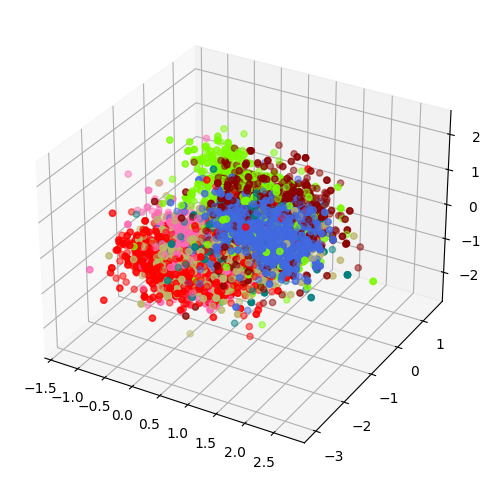

In [154]:
from utils import *
plot_scatter3D(df)

# T-sne

[ 20.872576 -38.82335 ]


/tmp/ipykernel_60470/2634126881.py:17: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=data.target, legend='full', palette=palette)


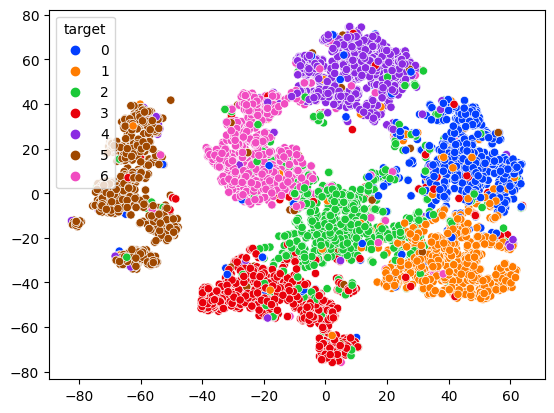

In [155]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)
# data를 가지고 TSNE 모델을 훈련(적용) 합니다.
X_embedded = model.fit_transform(df.iloc[:,:-1])
# 훈련된(차원 축소된) 데이터의 첫번째 값을 출력해 봅니다. 
print(X_embedded[0])
# [65.49378 -7.3817754]

# 차원 축소된 데이터를 그래프로 만들어서 화면에 출력해 봅니다.
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=data.target, legend='full', palette=palette)
plt.show()

In [11]:
#0: IT과학
#1: 경제
#2: 사회
#3: 생활문화
#4: 세계
#5: 스포츠
#6: 정치

# GMM

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings

In [192]:
import numpy as np
from sklearn.datasets import make_blobs # Clustering 데이터 생성을 위해
from sklearn.mixture import GaussianMixture

df_embedded = pd.DataFrame(X_embedded)


X, y = df_embedded, data['target']
gmm = GaussianMixture(n_components=7, random_state=42, max_iter=20)
gmm.fit(X)

gmm.means_ #gmm의 mean 값들을 확인 가능
gmm.weights_ #gmm의 weight 값들을 확인 가능
gmm.covariances_ #gmm의 공분산 행렬 확인 가능

gmm.predict(X) #각 point가 어느 Cluster에 포함되는지 결과를 확인
gmm.predict_proba(X) #각 point가 각 Cluster에 포함될 확률 (point 당 n_components개 만큼)

array([[8.08520715e-06, 2.74921721e-02, 2.32725214e-19, ...,
        3.00588576e-03, 9.69493856e-01, 4.40630185e-31],
       [9.15523190e-01, 3.97372337e-02, 1.00148859e-07, ...,
        4.52793239e-15, 4.47394756e-02, 4.35514438e-39],
       [9.96784092e-01, 1.15411583e-06, 1.70431235e-11, ...,
        1.40630197e-21, 3.21475401e-03, 1.72955122e-58],
       ...,
       [2.02909935e-07, 1.15128739e-01, 2.07635444e-04, ...,
        1.37494628e-09, 1.01136891e-05, 1.27670687e-12],
       [2.10419312e-13, 9.27823265e-07, 9.51952122e-05, ...,
        2.76108592e-11, 2.95852525e-11, 1.20528412e-05],
       [1.26422660e-16, 1.23366084e-02, 4.15546784e-22, ...,
        9.87613456e-01, 1.06473812e-05, 4.72624823e-12]])

In [207]:
pred = pd.DataFrame(gmm.predict(X))
X = pd.DataFrame(X)
y = pd.DataFrame(y)

final = pd.concat([X,y,pred],axis=1)
final.columns = ['vec1', 'vec2', 'target', 'pred']

/tmp/ipykernel_60470/3887674291.py:2: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['target'], legend='full', palette=palette)


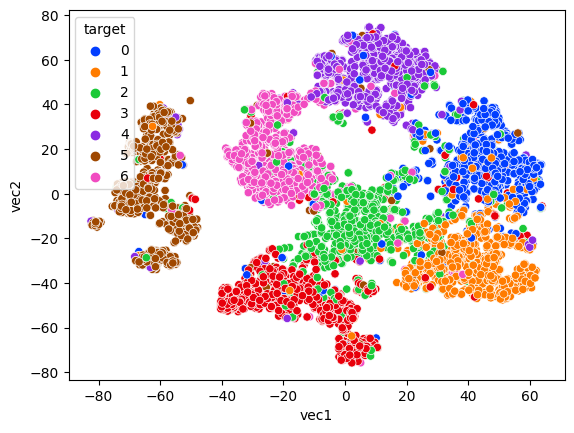

/tmp/ipykernel_60470/3887674291.py:4: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)


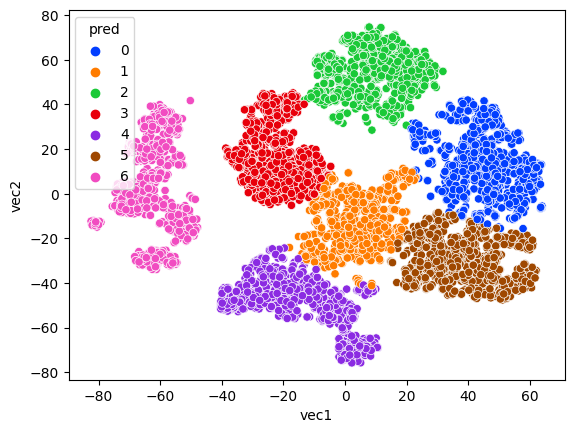

In [208]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['target'], legend='full', palette=palette)
plt.show()
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)
plt.show()

In [209]:
pred_dic = {0:0, 5:1, 1:2, 4:3, 2:4, 6:5, 3:6}
final['pred'] = final['pred'].map(lambda x: pred_dic[x])

changed = final[final['target']!= final['pred']].index.tolist()
changed

In [215]:
#kor_dic = {0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}

final_df = pd.concat([final, data[['ID','text']]],axis=1).iloc[changed]
#final_df['target'] = final_df['target'].apply(lambda x:kor_dic[x])
#final_df['pred'] = final_df['pred'].apply(lambda x:kor_dic[x])

In [216]:
final_df.head(50)
final_df.to_csv(os.path.join(DATA_DIR,'noise_clustered.csv'), index=False)